In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from arch import arch_model
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

#from validate_pipeline import run_full_validation

In [2]:
# -----------------------
# Reproducibility
# -----------------------
SEED = 0
np.random.seed(SEED)
# xgboost uses seed param inside params
# -----------------------
# Logging
# -----------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger("vol_demo")

In [3]:
X = pd.read_csv('/home/tatiana/Downloads/supp_material/X_train.csv')
Y = pd.read_csv('/home/tatiana/Downloads/supp_material/y_train.csv')
X_test = pd.read_csv('/home/tatiana/Downloads/supp_material/X_test.csv')

## Data description
- This data was taken from a ML challenge competition, therefore I am not sure I can freely post the datasets. In case of interest, you can easily retrieve the data here: https://challengedata.ens.fr/participants/challenges/97/ 
- X contains 35 columns of self-explanatory exogenous variables related to a coupled power market of France and Germany. See print of the variable names here:
  ['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET']

- Y contains price changes for daily futures contracts of 24H electricity baseload for these countries. X and Y datasets have an 'ID' variable as a common identifier.
- Attention! ID != DAY_ID, therefore I sorted them first by ID, then just merged sorted X and Y into one Dataframe, then sorted by DAY_ID to set the time sequence correctly.
- Some days contain information for both countries, some only for FR or DE. Needs to be taken into account when computing lags per country etc.

In [4]:
# Ensure we only load once and use sorted align
X = X.sort_values('ID').reset_index(drop=True)
Y = Y.sort_values('ID').reset_index(drop=True)

if not (X['ID'].values == Y['ID'].values).all():
    raise ValueError('X and Y IDs do not match after sorting')
log.info('X and Y correctly aligned by ID')

# Merge into single DF (keep original X columns plus TARGET as volatility)
df = X.copy()
df['volatility'] = Y['TARGET'].values

# Convert DAY_ID to int if not already
if not np.issubdtype(df['DAY_ID'].dtype, np.number):
    try:
        df['DAY_ID'] = pd.to_datetime(df['DAY_ID'])
    except Exception:
        pass

# Sort for time operations
df = df.sort_values(['COUNTRY', 'DAY_ID']).reset_index(drop=True)

# -----------------------
# Basic lags and flags (robust grouped rolling)
# -----------------------
# simple lags for volatility
for lag in [1, 3, 7]:
    df[f'vol_lag{lag}'] = df.groupby('COUNTRY')['volatility'].shift(lag)

# country flag
df['IS_FR'] = (df['COUNTRY'] == 'FR').astype(int)

2026-02-04 23:07:34,354 INFO X and Y correctly aligned by ID


## Engineered features block

- Not all of them should used, here are just ideas to be tested. Too many -- bad, too few -- also not good.
- Features should be chosen based on what the ML model CAN properly learn. Mostly monotonic persistent relationships. That is:
    - Likely not weather spikes (so no raw weather data)
    - Likely not individual power outages
    - Likely not market news jumps
- But rather structural stress variables:
    - Volatility lags themselves, as long as volatility memory is there
    - System stress
    - Cross-border congestion
    - Fuel/merit order shocks
    - Renewable penetration regime 

In [5]:
# Cross-country spreads 
df['LOAD_IMBALANCE'] = df['DE_RESIDUAL_LOAD'] - df['FR_RESIDUAL_LOAD']
df['WIND_IMBALANCE'] = df['DE_WINDPOW'] - df['FR_WINDPOW']
df['SOLAR_IMBALANCE'] = df['DE_SOLAR'] - df['FR_SOLAR']
# nuclear imbalance: FR - DE 
df['NUCLEAR_IMBALANCE'] = df['FR_NUCLEAR'] - df['DE_NUCLEAR']

# Exchange stress and totals
# keep sign preserved
df['FLOW_PRESSURE'] = df['DE_FR_EXCHANGE'] - df['FR_DE_EXCHANGE']
df['TOTAL_FLOW'] = df['DE_FR_EXCHANGE'].abs() + df['FR_DE_EXCHANGE'].abs()

# Residual stress
# beware of dividing by zero - add small epsilon
eps = 1e-8
df['DE_RESIDUAL_STRESS'] = df['DE_RESIDUAL_LOAD'] / (df['DE_CONSUMPTION'] + eps)
df['FR_RESIDUAL_STRESS'] = df['FR_RESIDUAL_LOAD'] / (df['FR_CONSUMPTION'] + eps)

# Fuel stress
df['GAS_COAL_SPREAD'] = df['GAS_RET'] - df['COAL_RET']
df['CARBON_PRESSURE'] = df['CARBON_RET'] * (df['DE_COAL'] + df['DE_LIGNITE'])

# regime flags
# rolling mean of GAS_RET per country
df['GAS_RET_30m'] = df.groupby('COUNTRY')['GAS_RET'].transform(lambda x: x.rolling(30, min_periods=1).mean().shift(1))
df['LOAD_TREND_30'] = df.groupby("COUNTRY")['DE_RESIDUAL_LOAD'].transform(
    lambda x: x.rolling(30, min_periods=10).mean()
)

# REL_RENEWABLE
df['REL_RENEWABLE'] = (df['DE_WINDPOW'] + df['DE_SOLAR']) - (df['FR_WINDPOW'] + df['FR_SOLAR'])

# Temperature, wind, rain anomalies -> ensure grouped rolling and shifted (no future leak)
weather_cols = [c for c in df.columns if c.endswith('_TEMP') or c.endswith('_WIND') or c.endswith('_RAIN')]
for c in ['DE_TEMP', 'FR_TEMP', 'DE_WIND', 'FR_WIND', 'DE_RAIN', 'FR_RAIN']:
    if c in df.columns:
        df[f'{c}_ANOM'] = df.groupby('COUNTRY')[c].transform(lambda x: x.rolling(7, min_periods=3).mean())
        df[f'{c}_ANOM'] = df[c] - df[f'{c}_ANOM']

# -----------------------
# Additional engineered features: lags, rolling moments, percentiles, interactions
# -----------------------
# Rolling stats for volatility (per country)
for w in [7, 30]:
    df[f'vol_roll_std_{w}'] = df.groupby('COUNTRY')['volatility'].transform(lambda x: x.rolling(w, min_periods=3).std())
    df[f'vol_roll_mean_{w}'] = df.groupby('COUNTRY')['volatility'].transform(lambda x: x.rolling(w, min_periods=3).mean())

# rolling stats for DE_RESIDUAL_LOAD and DE_WINDPOW
for col in ['DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_CONSUMPTION', 'FR_CONSUMPTION']:
    if col in df.columns:
        for w in [3,7,30]:
            df[f'{col}_rm_{w}'] = df.groupby('COUNTRY')[col].transform(lambda x: x.rolling(w, min_periods=2).mean())
            df[f'{col}_std_{w}'] = df.groupby('COUNTRY')[col].transform(lambda x: x.rolling(w, min_periods=2).std())

# interaction terms
if 'LOAD_IMBALANCE' in df.columns and 'GAS_RET' in df.columns:
    df['LOADxGAS'] = df['LOAD_IMBALANCE'] * df['GAS_RET_30m']

# cross-sectional rank within day for some features - useful when training to rank
rank_cols = ['DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'LOAD_IMBALANCE', 'TOTAL_FLOW']
for c in rank_cols:
    if c in df.columns:
        df[f'{c}_day_rank'] = df.groupby('DAY_ID')[c].transform(lambda x: x.rank(method='average')/len(x))

# make sure rolling features don't accidentally use current value for training later - 
#they are computed as functions of past when shifted in modeling steps

In [6]:
#verify GAS_RET_30m was lagged
if 'GAS_RET_30m' in df.columns:
    check = df.groupby('COUNTRY')['GAS_RET'].transform(lambda x: x.rolling(30, min_periods=1).mean().shift(1))
    corr = df[['GAS_RET_30m', 'GAS_RET_30m_check']].dropna().corr().iloc[0,1] if 'GAS_RET_30m_check' in df else None
    if corr is not None and corr < 0.999:
        print("Warning: GAS_RET_30m differs from lagged check. Recompute with shift(1).")


## GARCH part

In [7]:
# -----------------------
# GARCH rolling forecast per country (leak-free) - keep start/end indices explicit
# -----------------------
garch_window = 500
min_obs = 300

# Create garch_vol and store successful fit count
df = df.sort_values(['COUNTRY','DAY_ID']).reset_index(drop=True)
df['garch_vol'] = np.nan
df['garch_stdresid'] = np.nan  # standardized residual

for country in df['COUNTRY'].unique():
    df_c_idx = df[df['COUNTRY']==country].index
    returns = df.loc[df_c_idx, 'volatility'].values

    success_count = 0
    for local_t in range(len(returns)):
        if local_t < min_obs:
            continue
        start = max(0, local_t - garch_window)
        end = local_t  # up to t-1
        window = returns[start:end]
        if len(window) < min_obs:
            continue
        try:
            am = arch_model(window, vol='Garch', p=1, q=1, dist='t', rescale=False)
            res = am.fit(disp='off', update_freq=0, show_warning=False)
            fcast = res.forecast(horizon=1, reindex=False)
            sigma_t = np.sqrt(fcast.variance.values[-1,0])
            # place into global df at corresponding index
            global_idx = df_c_idx[start + (len(window))] if False else df_c_idx[local_t]
            df.loc[df_c_idx[local_t], 'garch_vol'] = sigma_t
            # compute standardized residual for local_t (current observed vol / sigma)
            std_resid = returns[local_t] / (sigma_t + eps)
            df.loc[df_c_idx[local_t], 'garch_stdresid'] = std_resid
            success_count += 1
        except Exception as e:
            # log once per exception type if needed
            continue
    log.info(f'Country {country}: successful GARCH preds: {int(success_count)}')

# Drop rows without garch forecast (cannot build residual)
df = df.dropna(subset=['garch_vol']).reset_index(drop=True)
log.info(f'After dropping NaN garch_vol rows, {len(df)} observations remain')

2026-02-04 23:07:57,391 INFO Country DE: successful GARCH preds: 343
2026-02-04 23:08:22,173 INFO Country FR: successful GARCH preds: 551
2026-02-04 23:08:22,175 INFO After dropping NaN garch_vol rows, 894 observations remain


## ML part

In [8]:
# raw residual
df['residual_target'] = df['volatility'] - df['garch_vol']
# optional smoothed target for experiments, backwards smoothing --> no data leakage
df['residual_target_smooth'] = df.groupby('COUNTRY')['residual_target'].transform(lambda x: x.rolling(5, min_periods=1).mean())

In [9]:
# Prepare features list
base_features = [
    'vol_lag1', 'vol_lag3', 'vol_lag7',
    'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD',
    'LOAD_IMBALANCE', 'FLOW_PRESSURE', 'TOTAL_FLOW',
    'DE_RESIDUAL_STRESS', 'FR_RESIDUAL_STRESS',
    'GAS_COAL_SPREAD', 'CARBON_PRESSURE', 'HIGH_GAS_REGIME',
    'REL_RENEWABLE', 'vol_roll_std_7', 'vol_roll_std_30', 'GAS_RET_30m'
]

In [10]:
# add any of the engineered features if present
extras = [c for c in df.columns if any(suffix in c for suffix in ['_rm_','_std_','_day_rank','LOADxGAS'])]
features = base_features #+ 'GAS_RET_60m' #extras
# remove missing columns 
features = [f for f in features if f in df.columns]
log.info(f'Number of features used: {len(features)}')

# Fill NA with median per country for features (deterministic, no leak)
for f in features:
    df[f] = df.groupby('COUNTRY')[f].transform(lambda x: x.fillna(x.median()))
    # if still NA (constant column), fill global median
    df[f] = df[f].fillna(df[f].median())

2026-02-04 23:08:22,214 INFO Number of features used: 16


In [11]:
# -----------------------
# Rolling ML (time-aware) to produce OOS predictions
# -----------------------
train_window = 280  # days
test_horizon = 21
unique_days = np.sort(df['DAY_ID'].unique())
log.info(f'Unique days: {len(unique_days)}')

# XGBoost params 
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.02,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'lambda': 20,
    'alpha': 5,
    'min_child_weight': 30,
    'seed': SEED
}

predictions = []
rolling_train_spearman = []
rolling_test_spearman = []

# Perform rolling training; for each fold create a small time validation at tail of train
for i in range(train_window, len(unique_days) - test_horizon + 1, test_horizon):
    train_days = unique_days[i-train_window:i]
    test_days = unique_days[i:i+test_horizon]

    train_idx = df['DAY_ID'].isin(train_days)
    test_idx = df['DAY_ID'].isin(test_days)

    X_train = df.loc[train_idx, features].copy()
    y_train = df.loc[train_idx, 'residual_target']

    X_test = df.loc[test_idx, features].copy()
    y_test = df.loc[test_idx, 'residual_target']

    # create time-ordered validation split from tail of X_train for early stopping
    val_fraction = 0.15
    if len(X_train) < 50:
        X_tr, y_tr = X_train, y_train
        X_val, y_val = X_test, y_test
    else:
        split_point = int((1 - val_fraction) * len(X_train))
        X_tr = X_train.iloc[:split_point]
        y_tr = y_train.iloc[:split_point]
        X_val = X_train.iloc[split_point:]
        y_val = y_train.iloc[split_point:]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    train_pred = model.predict(xgb.DMatrix(X_tr))
    test_pred = model.predict(dtest)

    rolling_train_spearman.append(spearmanr(train_pred, y_tr).correlation)
    rolling_test_spearman.append(spearmanr(test_pred, y_test).correlation)

    predictions.append(pd.DataFrame({
        'DAY_ID': df.loc[test_idx, 'DAY_ID'].values,
        'COUNTRY': df.loc[test_idx, 'COUNTRY'].values,
        'pred_residual': test_pred,
        'true_residual': y_test.values
    }))

# Concat and merge on DAY_ID+COUNTRY (avoid cartesian product)
pred_df = pd.concat(predictions, ignore_index=True)
# ensure no duplicates
pred_df = pred_df.drop_duplicates(subset=['DAY_ID', 'COUNTRY'])

# Merge back
df = df.merge(pred_df, on=['DAY_ID', 'COUNTRY'], how='left')

# Final predicted vol
df['pred_vol'] = df['garch_vol'] + df['pred_residual']
# Spearman evaluation for ML residuals only where pred exists
mask = df['pred_residual'].notna()
overall_test_rho = spearmanr(df.loc[mask, 'pred_residual'], df.loc[mask, 'true_residual']).correlation
log.info(f'Overall test Spearman (ML residuals): {overall_test_rho:.4f}')
log.info(f'Mean rolling train Spearman: {np.nanmean(rolling_train_spearman):.4f}')
log.info(f'Mean rolling test Spearman: {np.nanmean(rolling_test_spearman):.4f}')

2026-02-04 23:08:22,244 INFO Unique days: 551
2026-02-04 23:08:30,995 INFO Overall test Spearman (ML residuals): 0.2807
2026-02-04 23:08:30,996 INFO Mean rolling train Spearman: 0.5711
2026-02-04 23:08:30,996 INFO Mean rolling test Spearman: 0.3039


In [12]:
# overall pooled spearman (only where pred exists) --> global rank stability across all samples
mask = df['pred_residual'].notna()
pooled_rho = spearmanr(df.loc[mask,'pred_residual'], df.loc[mask,'true_residual']).correlation
print("Pooled overall Spearman:", pooled_rho)

# mean of rolling_test_spearman you already track; compute median/IQR too --> av. local window predictability
print("Rolling test Spearman mean:", np.nanmean(rolling_test_spearman))
print("Rolling test Spearman median:", np.nanmedian(rolling_test_spearman))
print("Rolling test Spearman std:", np.nanstd(rolling_test_spearman))

# per-day Spearman distribution (day-level ranks) --> % correct ranking
day_rhos = []
for d in df.loc[mask,'DAY_ID'].unique():
    sub = df[(df['DAY_ID']==d) & mask]
    if len(sub) > 1:
        day_rhos.append(spearmanr(sub['pred_residual'], sub['true_residual']).correlation)
day_rhos = np.array([r for r in day_rhos if not np.isnan(r)])

print("Per-day rho mean:", day_rhos.mean(), "median:", np.median(day_rhos), "count:", len(day_rhos))
print("Correct ranking on, days [%]:", 100*(day_rhos.mean()+1)/2)

Pooled overall Spearman: 0.28067157793304287
Rolling test Spearman mean: 0.3038710309938963
Rolling test Spearman median: 0.4073833231727968
Rolling test Spearman std: 0.27643258207500543
Per-day rho mean: 0.33333333333333326 median: 0.9999999999999999 count: 177
Correct ranking on, days [%]: 66.66666666666666


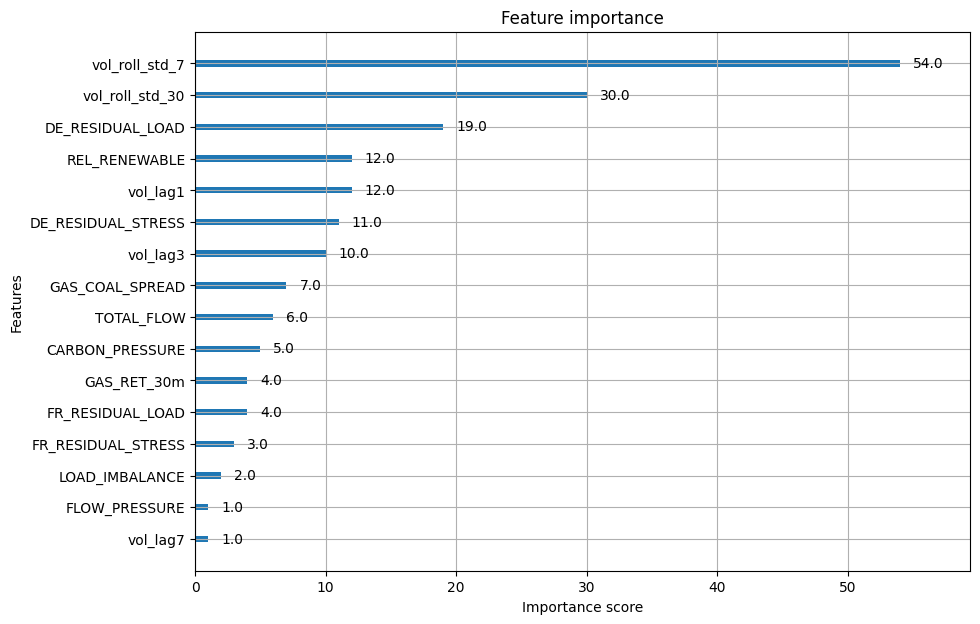

In [13]:
plt.rcParams["figure.figsize"] = (10, 7)
xgb.plot_importance(model);

## Validation

In [37]:
# -----------------------
# Ranking objective example (XGBoost rank:pairwise) - train on full training windows
# -----------------------
# Demonstrate a single retrain on everything except final holdout
holdout_days = unique_days[-90:]
train_days_full = unique_days[unique_days < holdout_days[0]]

train_mask = df['DAY_ID'].isin(train_days_full)
holdout_mask = df['DAY_ID'].isin(holdout_days)

# Prepare rank labels: within each day, the higher residual_target should have higher rank
# Use raw residual_target here
rank_train_df = df.loc[train_mask, ['DAY_ID'] + features + ['residual_target', 'COUNTRY']].copy()
# sort by DAY_ID to produce contiguous groups
rank_train_df = rank_train_df.sort_values('DAY_ID').reset_index(drop=True)
groups = rank_train_df.groupby('DAY_ID').size().tolist()
labels = rank_train_df['residual_target'].values

dtrain_rank = xgb.DMatrix(rank_train_df[features], label=labels)
# set_group requires list of group sizes
try:
    dtrain_rank.set_group(groups)
except Exception:
    log.warning('Could not set groups for rank training - check DAY_ID groups')

params_rank = params.copy()
params_rank['objective'] = 'rank:pairwise'
params_rank['eval_metric'] = 'map'

model_rank = xgb.train(params_rank, dtrain_rank, num_boost_round=500)

# Predict on holdout and compute spearman on holdout grouped by day
hold_df = df.loc[holdout_mask, ['DAY_ID', 'COUNTRY'] + features + ['residual_target']].copy()
hold_df = hold_df.sort_values(['DAY_ID', 'COUNTRY']).reset_index(drop=True)
pred_hold_rank = model_rank.predict(xgb.DMatrix(hold_df[features]))

# evaluate spearman per day and aggregate
day_rhos = []
for d in hold_df['DAY_ID'].unique():
    sub = hold_df[hold_df['DAY_ID']==d]
    idx = sub.index
    if len(idx) <= 1:
        continue
    rho = spearmanr(pred_hold_rank[sub.index - hold_df.index[0]], sub['residual_target']).correlation
    if not np.isnan(rho):
        day_rhos.append(rho)
log.info(f'Mean holdout Spearman for rank model (day-averaged): {np.nanmean(day_rhos):.4f}')

2026-02-04 23:00:57,675 INFO Mean holdout Spearman for rank model (day-averaged): 0.3448


In [38]:
# -----------------------
# Holdout regression baseline (pure ML on raw vol) for comparison
# -----------------------
X_hold_train = df.loc[train_mask, features]
y_hold_train = df.loc[train_mask, 'volatility']
X_hold_test = df.loc[holdout_mask, features]
y_hold_test = df.loc[holdout_mask, 'volatility']

dtr = xgb.DMatrix(X_hold_train, label=y_hold_train)
dte = xgb.DMatrix(X_hold_test)
model_raw = xgb.train(params, dtr, num_boost_round=500)
pred_raw = model_raw.predict(dte)
rho_raw, p_raw = spearmanr(pred_raw, y_hold_test.values)
log.info(f'Pure ML holdout Spearman (volatility): {rho_raw:.4f}')

2026-02-04 23:01:00,142 INFO Pure ML holdout Spearman (volatility): 0.0946


In [39]:
# -----------------------
# Diagnostics & Permutation test (empirical p-value) for pred_hold from regression example earlier
# -----------------------
# Here use the earlier rolling ML aggregate pred_hold (if exists); otherwise use pred_raw
try:
    test_preds = pred_hold_rank
    test_truth = hold_df['residual_target'].values
except Exception:
    test_preds = pred_raw
    test_truth = y_hold_test.values

n_perm = 500
count = 0
for _ in range(n_perm):
    shuffled = np.random.permutation(test_truth)
    rho_null, _ = spearmanr(test_preds, shuffled)
    if abs(rho_null) >= abs(spearmanr(test_preds, test_truth).correlation):
        count += 1
p_empirical = (count + 1) / (n_perm + 1)
log.info(f'Empirical permutation p-value: {p_empirical:.4f}')

2026-02-04 23:01:03,911 INFO Empirical permutation p-value: 0.0020


## Trading strategy

In [40]:
# -----------------------
# Trading strategy 
# -----------------------
# Build backtest table from df rows that have predictions
bt = df.loc[df['pred_residual'].notna(), ['DAY_ID', 'COUNTRY', 'pred_residual', 'residual_target', 'volatility']].copy()
bt = bt.rename(columns={'pred_residual': 'pred', 'residual_target': 'true_res'})
# ensure correct sorted order
bt = bt.sort_values(['COUNTRY', 'DAY_ID']).reset_index(drop=True)

# Cross-sectional normalization per day
bt['pred_cs'] = bt['pred'] - bt.groupby('DAY_ID')['pred'].transform('mean')
bt['vol_cs'] = bt['true_res'] - bt.groupby('DAY_ID')['true_res'].transform('mean')

# rolling z-score per country - compute past mean/std only (shift by 1)
lookback = 30
bt['pred_mean_past'] = bt.groupby('COUNTRY')['pred_cs'].transform(lambda x: x.rolling(lookback, min_periods=5).mean().shift(1))
bt['pred_std_past'] = bt.groupby('COUNTRY')['pred_cs'].transform(lambda x: x.rolling(lookback, min_periods=5).std().shift(1))
# avoid div by zero
bt['pred_std_past'] = bt['pred_std_past'].fillna(bt['pred_std_past'].median()).replace(0, 1e-6)

bt['z'] = (bt['pred_cs'] - bt['pred_mean_past']) / bt['pred_std_past']
bt['z'] = bt['z'].fillna(0)

# threshold signal
threshold = 0.5
bt['signal_raw'] = np.where(bt['z'].abs() > threshold, bt['z'], 0)
# clip
bt['signal'] = bt['signal_raw'].clip(-2, 2)

# Position sizing: normalize daily so sum(abs(position)) = 1 (equal absolute exposure across days)
bt['abs_sig'] = bt.groupby('DAY_ID')['signal'].transform(lambda x: x.abs())
# To avoid division by zero, compute per day sum of abs
daily_abs = bt.groupby('DAY_ID')['abs_sig'].transform('sum').replace(0, np.nan)
bt['position'] = bt['signal'] / daily_abs
bt['position'] = bt['position'].fillna(0)

# Transaction costs model: cost per turnover * abs(change in position)
cost_bps = 0.0005  # 0.05% per unit notional (adjust as realistic)
# compute turnover per country as change in position day-to-day
bt['prev_pos'] = bt.groupby('COUNTRY')['position'].shift(1).fillna(0)
bt['turnover'] = (bt['position'] - bt['prev_pos']).abs()
bt['tcost'] = bt['turnover'] * cost_bps

# PnL (simple): position * vol_cs  - tcost
bt['pnl_raw'] = bt['position'] * bt['vol_cs']
bt['pnl'] = bt['pnl_raw'] - bt['tcost']

# Aggregate daily PnL
daily_pnl = bt.groupby('DAY_ID')['pnl'].sum()

# Sharpe (annualized)
sharpe = daily_pnl.mean() / (daily_pnl.std() + 1e-9) * np.sqrt(252)
log.info(f'Sharpe (with costs): {sharpe:.4f}')

# Max drawdown
cum = daily_pnl.cumsum()
roll_max = cum.cummax()
drawdown = cum - roll_max
max_dd = drawdown.min()
log.info(f'Max drawdown: {max_dd:.4f}')

# Turnover summary
avg_turnover = bt.groupby('DAY_ID')['turnover'].sum().mean()
log.info(f'Average daily turnover (sum abs): {avg_turnover:.6f}')

# threshold sweep to find best threshold (recompute quickly)
best_sharpe = -np.inf
best_thr = None
for thr in np.arange(0.3, 1.6, 0.1):
    bt['signal_tmp'] = np.where(bt['z'].abs() > thr, bt['z'], 0)
    bt['signal_tmp'] = bt['signal_tmp'].clip(-2, 2)
    bt['abs_sig_tmp'] = bt.groupby('DAY_ID')['signal_tmp'].transform(lambda x: x.abs())
    daily_abs_tmp = bt.groupby('DAY_ID')['abs_sig_tmp'].transform('sum').replace(0, np.nan)
    bt['pos_tmp'] = (bt['signal_tmp'] / daily_abs_tmp).fillna(0)
    bt['prev_pos_tmp'] = bt.groupby('COUNTRY')['pos_tmp'].shift(1).fillna(0)
    bt['turn_tmp'] = (bt['pos_tmp'] - bt['prev_pos_tmp']).abs()
    bt['tcost_tmp'] = bt['turn_tmp'] * cost_bps
    bt['pnl_tmp'] = (bt['pos_tmp'] * bt['vol_cs']) - bt['tcost_tmp']
    daily_pnl_tmp = bt.groupby('DAY_ID')['pnl_tmp'].sum()
    sharpe_tmp = daily_pnl_tmp.mean() / (daily_pnl_tmp.std() + 1e-9) * np.sqrt(252)
    if sharpe_tmp > best_sharpe:
        best_sharpe = sharpe_tmp
        best_thr = thr

log.info(f'Optimal threshold (sweep): {best_thr:.2f}, Sharpe: {best_sharpe:.4f}')

2026-02-04 23:01:07,965 INFO Sharpe (with costs): 2.3480
2026-02-04 23:01:07,966 INFO Max drawdown: -6.8209
2026-02-04 23:01:07,968 INFO Average daily turnover (sum abs): 0.608595
2026-02-04 23:01:08,149 INFO Optimal threshold (sweep): 1.10, Sharpe: 3.0054


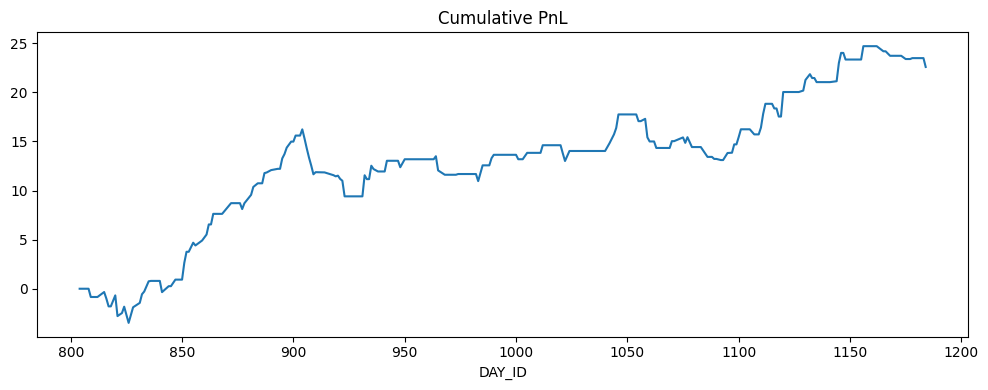

In [41]:
try:
    plt.figure(figsize=(10,4))
    daily_pnl.cumsum().plot(title='Cumulative PnL')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'cum_pnl.png'))
    plt.close()
except Exception:
    pass